In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle
import seaborn as sns
import geopandas as gpd
from scipy import stats

pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import warnings
warnings.filterwarnings('ignore')

In [27]:
# Health Services & 80XX \\
# Drugstores & 5122, 5912\\
# Restaurants & 5461, 5812, 5813 \\
# Groceries & 5141, 5411\\
# Cultural Institutions & 79XX  \\
# Services &  4311, 60XX, 72XX, 73XX\\
def add_poi_type_new(df):
    df['category'] = 'N/A'
    df.loc[df['sic_code'].isna(),'category'] = 'N/A'
    
    df.loc[(df['sic_code']>=8000)&(df['sic_code']<=8099),'category'] = 'Healthcare'
    df.loc[df['sic_code'].isin([5122,5912]),'category'] = 'Drugstores'
    # df.loc[(df['sic_code']>=8200)&(df['sic_code']<=8299),'category'] = 'Schools' #there is no school in our data
    df.loc[df['sic_code'].isin([8661]),'category'] = 'Religious Organizations'  ##there is no Religious in our data
    df.loc[df['sic_code'].isin([5461, 5812, 5813]),'category'] = 'Restaurants'
    df.loc[df['sic_code'].isin([5141, 5411]),'category'] = 'Groceries'
    df.loc[df['sic_code'].isin([8422]),'category'] = 'Parks'  # there is no park in our data
    df.loc[(df['sic_code']>=7900)&(df['sic_code']<=7999),'category'] = 'Entertainment Establishments'

    df.loc[(df['sic_code']>=6000)&(df['sic_code']<=6099),'category'] = 'Services'
    df.loc[(df['sic_code']>=7200)&(df['sic_code']<=7299),'category'] = 'Services'
    df.loc[(df['sic_code']>=7300)&(df['sic_code']<=7399),'category'] = 'Services'
    df.loc[df['sic_code'].isin([4311]),'category'] = 'Services'
    return df

# Get each POI's home based diversity

In [28]:
POIcat = pd.read_pickle("data/LA_POI_category.pkl")

home_diversity = pd.read_pickle("data/CA_CBG_dominantRace.pkl") # residential diversity (CBG level) for all California CBGs
print(home_diversity.shape[0])
home_diversity = home_diversity[home_diversity['scaled_entropy'].notna()]
print(home_diversity.shape[0])

df_poi_CBG = pd.read_pickle('data/LA_POI_belong_CBG.pkl') # each POI belongs to which CBG
df_poi_CBG_merged = pd.merge(df_poi_CBG,home_diversity,on='block_group_id')
df_poi_CBG_mergedneed = df_poi_CBG_merged[['place_id','scaled_entropy','class_dominant']]
df_poi_CBG_mergedneed.rename(columns={'scaled_entropy': 'home_scaled_entropy','class_dominant':'home_class_dominant'}, inplace=True)
print(df_poi_CBG_mergedneed.shape[0]) # for each POI's residential diversity
df_poi_CBG_mergedneed.head(2)

23212
23141
61968


,place_id,home_scaled_entropy,home_class_dominant
0,25609839,0.096533,R_HispanicLatinx_low diversity
1,31157976,0.096533,R_HispanicLatinx_low diversity


# Merge all time periods and keep only common rows

In [29]:
weekday = True #False True
if weekday:
    diversity_nighttime = pd.read_pickle("data/LA_POI_diversity_201903_weekday_nighttime.pkl")  
    diversity_morning = pd.read_pickle("data/LA_POI_diversity_201903_weekday_morning.pkl")  
    diversity_noon = pd.read_pickle("data/LA_POI_diversity_201903_weekday_noon.pkl")
    diversity_afternoon = pd.read_pickle("data/LA_POI_diversity_201903_weekday_afternoon.pkl")
    diversity_evening = pd.read_pickle("data/LA_POI_diversity_201903_weekday_evening.pkl")
    title = 'Weekday'
else: #weekend
    diversity_nighttime = pd.read_pickle("data/LA_POI_diversity_201903_weekend_nighttime.pkl")  
    diversity_morning = pd.read_pickle("data/LA_POI_diversity_201903_weekend_morning.pkl")  
    diversity_noon = pd.read_pickle("data/LA_POI_diversity_201903_weekend_noon.pkl")
    diversity_afternoon = pd.read_pickle("data/LA_POI_diversity_201903_weekend_afternoon.pkl")
    diversity_evening = pd.read_pickle("data/LA_POI_diversity_201903_weekend_evening.pkl")
    title = 'Weekend'

print(diversity_nighttime.shape[0],diversity_morning.shape[0],diversity_noon.shape[0],diversity_afternoon.shape[0],diversity_evening.shape[0])

4082 29578 31891 32655 27275


In [30]:
def process_one_period(df):
    df = df[['place_id','scaled_entropy','poi_lat','poi_lng','class_dominant','sic_code']]
    df = df.dropna()
    df = add_poi_type_new(df)
    # df = df[df['category']!='N/A']
    # df.category.value_counts()
    df = pd.merge(df,df_poi_CBG_mergedneed,on='place_id',how='left')
    print(df.shape[0])
    return df

diversity_morning = process_one_period(diversity_morning)
diversity_noon = process_one_period(diversity_noon)
diversity_afternoon = process_one_period(diversity_afternoon)
diversity_evening = process_one_period(diversity_evening)

28016
29829
30297
25240


In [31]:
diversity_morning['period'] = 'Morning'
diversity_noon['period'] = 'Noon'
diversity_afternoon['period'] = 'Afternoon'
diversity_evening['period'] = 'Evening'

In [49]:
df_all = pd.concat([diversity_morning, diversity_noon])
df_all = pd.concat([df_all, diversity_afternoon])
df_all = pd.concat([df_all, diversity_evening])
print(df_all.shape[0])
df_all = df_all.dropna()
print(df_all.shape[0])
print(df_all.category.unique())
print(df_all.home_class_dominant.unique())
df_all.head(2)

113382
111987
['N/A' 'Services' 'Entertainment Establishments' 'Restaurants' 'Groceries'
 'Drugstores' 'Healthcare']
['R_HispanicLatinx_moderate diversity' 'R_White_moderate diversity'
 'high diversity' 'R_Asian_moderate diversity' 'R_White_low diversity'
 'R_HispanicLatinx_low diversity' 'R_AfricanAmerican_moderate diversity'
 'R_AmericanIndianAlaska_low diversity' 'R_Asian_low diversity'
 'R_AfricanAmerican_low diversity' 'R_Other_moderate diversity']


,place_id,scaled_entropy,poi_lat,poi_lng,class_dominant,sic_code,category,home_scaled_entropy,home_class_dominant,period
0,25033527.0,0.658841,34.033524,-118.272158,R_HispanicLatinx_moderate diversity,5511.0,N/A,0.623505,R_HispanicLatinx_moderate diversity,Morning
1,25033543.0,0.695342,34.168174,-118.595764,R_White_moderate diversity,5511.0,N/A,0.521918,R_White_moderate diversity,Morning


# OLS

In [50]:
df_dummies = pd.get_dummies(df_all['period'],dtype=float)  # drop_first=True avoids the dummy variable trap
df_dummies = df_dummies.drop('Morning', axis=1) # use morning as the base category
df_all = pd.concat([df_all, df_dummies], axis=1)# Concatenate the dummy variables with the original DataFrame
df_all = df_all.drop('period', axis=1)# Drop the original categorical column

df_dummies = pd.get_dummies(df_all['category'],dtype=float)  # drop_first=True avoids the dummy variable trap
df_dummies = df_dummies.drop('N/A', axis=1) # use N/A as the base category
df_all = pd.concat([df_all, df_dummies], axis=1)# Concatenate the dummy variables with the original DataFrame
df_all = df_all.drop('category', axis=1)# Drop the original categorical column

df_dummies = pd.get_dummies(df_all['home_class_dominant'],dtype=float)  # drop_first=True avoids the dummy variable trap
df_dummies = df_dummies.drop('R_HispanicLatinx_low diversity', axis=1) # use R_HispanicLatinx_low diversity as the base category
df_all = pd.concat([df_all, df_dummies], axis=1)# Concatenate the dummy variables with the original DataFrame
df_all = df_all.drop('home_class_dominant', axis=1)# Drop the original categorical column

df_all.head(2)

,place_id,scaled_entropy,poi_lat,poi_lng,class_dominant,sic_code,home_scaled_entropy,Afternoon,Evening,Noon,Drugstores,Entertainment Establishments,Groceries,Healthcare,Restaurants,Services,R_AfricanAmerican_low diversity,R_AfricanAmerican_moderate diversity,R_AmericanIndianAlaska_low diversity,R_Asian_low diversity,R_Asian_moderate diversity,R_HispanicLatinx_moderate diversity,R_Other_moderate diversity,R_White_low diversity,R_White_moderate diversity,high diversity
0,25033527.0,0.658841,34.033524,-118.272158,R_HispanicLatinx_moderate diversity,5511.0,0.623505,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,25033543.0,0.695342,34.168174,-118.595764,R_White_moderate diversity,5511.0,0.521918,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [35]:
# df_all.scaled_entropy.hist()

In [51]:
df_all['log_scaled_entropy'] = np.log(df_all['scaled_entropy']+0.000001)
df_all['log_home_scaled_entropy'] = np.log(df_all['home_scaled_entropy']+0.000001)

In [52]:
df_all.columns

Index(['place_id', 'scaled_entropy', 'poi_lat', 'poi_lng', 'class_dominant', 'sic_code', 'home_scaled_entropy', 'Afternoon', 'Evening', 'Noon', 'Drugstores', 'Entertainment Establishments', 'Groceries', 'Healthcare', 'Restaurants', 'Services', 'R_AfricanAmerican_low diversity', 'R_AfricanAmerican_moderate diversity', 'R_AmericanIndianAlaska_low diversity', 'R_Asian_low diversity', 'R_Asian_moderate diversity', 'R_HispanicLatinx_moderate diversity', 'R_Other_moderate diversity', 'R_White_low diversity', 'R_White_moderate diversity', 'high diversity', 'log_scaled_entropy', 'log_home_scaled_entropy'], dtype='object')

In [69]:
y = df_all['scaled_entropy']
# y = df_all['log_scaled_entropy']
X = df_all[['home_scaled_entropy', 'R_AfricanAmerican_low diversity','R_AfricanAmerican_moderate diversity',
            'R_AmericanIndianAlaska_low diversity','R_Asian_low diversity','R_Asian_moderate diversity',
            'R_Other_moderate diversity','R_HispanicLatinx_moderate diversity','R_White_low diversity',
            'R_White_moderate diversity','high diversity','Noon', 'Afternoon', 'Evening','Drugstores','Entertainment Establishments',
            'Groceries','Restaurants','Services', 'Healthcare']]

In [60]:
# df_cor = X.corr()
# pd.DataFrame(np.linalg.inv(X.corr().values), index = df_cor.index, columns=df_cor.columns)

In [61]:
import statsmodels.api as sm

# X = df_all[['home_scaled_entropy', 'Noon', 'Afternoon', 'Evening','Drugstores','Entertainment Establishments',
#             'Groceries','Restaurants','Services', 'Healthcare']]

X = sm.add_constant(X)  # Adds a constant term to the independent variables matrix

# Fit the OLS model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         scaled_entropy   R-squared:                       0.336
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     2827.
Date:                Mon, 26 Aug 2024   Prob (F-statistic):               0.00
Time:                        14:33:56   Log-Likelihood:                 81879.
No. Observations:              111987   AIC:                        -1.637e+05
Df Residuals:                  111966   BIC:                        -1.635e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


((array([-4.37080331, -4.17310201, -4.06560903, ...,  4.06560903,
          4.17310201,  4.37080331]),
  array([-0.72750668, -0.72395575, -0.72352656, ...,  0.40739375,
          0.41930853,  0.42429452])),
 (0.11338372819518873, -3.5280648474686755e-16, 0.9734268475030105))

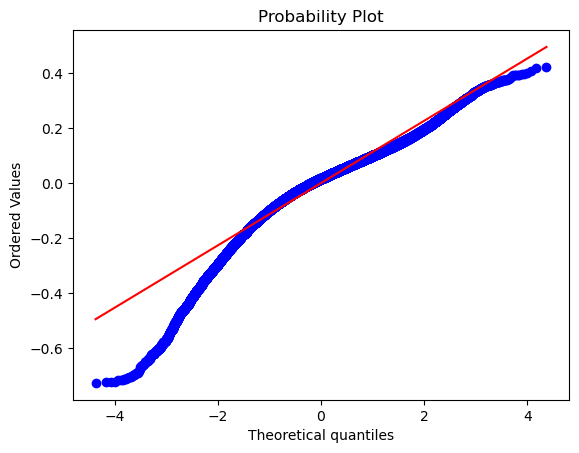

In [62]:
stats.probplot(model.resid, dist="norm", plot= plt)

In [63]:
import statsmodels.stats.api as sms
from statsmodels.compat import lzip

name = ['Lagrange multiplier statistic', 'p-value', 
        'f-value', 'f p-value']
test = sms.het_breuschpagan(model.resid, model.model.exog)
lzip(name, test)
# The test is significant meaning the data violates the assumption of homoscedasticity, i.e. heteroscedasticity is present in the data. 

[('Lagrange multiplier statistic', 4830.284849513212),
 ('p-value', 0.0),
 ('f-value', 252.3536078448645),
 ('f p-value', 0.0)]

# Beta regression

In [67]:
from statsmodels.othermod.betareg import BetaModel

In [73]:
mod = BetaModel(df_all['scaled_entropy'], df_all['home_scaled_entropy'])
rslt = mod.fit()
print(rslt.summary())

AssertionError: 

# Moran's I on OLS residuals

In [180]:
%%time 
from libpysal.weights import KNN
from esda.moran import Moran

# Create spatial weights matrix using K-Nearest Neighbors
coords = df_all[['poi_lat', 'poi_lng']].values
knn = KNN.from_array(coords, k=8)  # Change k as needed

# Compute Moran's I
residuals = model.resid
moran = Moran(residuals, knn)
print(f"Moran's I: {moran.I}")
print(f"P-value: {moran.p_sim}") 
# very strong spatial autocorrelation exists in the residual suggesting Spatial Models instead of OLS

Moran's I: 0.3709790954232149
P-value: 0.001
CPU times: user 3.88 s, sys: 1.22 s, total: 5.1 s
Wall time: 4.49 s


# LM test

### run OLS first for LM test

In [181]:
from pysal.model import spreg

y = df_all['scaled_entropy']
X = df_all[['home_scaled_entropy', 'R_AfricanAmerican_low diversity','R_AfricanAmerican_moderate diversity',
            'R_AmericanIndianAlaska_low diversity','R_Asian_low diversity','R_Asian_moderate diversity',
            'R_HispanicLatinx_low diversity','R_HispanicLatinx_moderate diversity','R_White_low diversity',
            'R_White_moderate diversity','high diversity','Noon', 'Afternoon', 'Evening','Drugstores','Entertainment Establishments',
            'Groceries','Restaurants','Services']]

ols = OLS(y.values, X.values, 
          name_y= y.name,
          name_x= X.columns.tolist())
print(ols.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :scaled_entropy                Number of Observations:       50806
Mean dependent var  :      0.6372                Number of Variables   :          20
S.D. dependent var  :      0.1408                Degrees of Freedom    :       50786
R-squared           :      0.3861
Adjusted R-squared  :      0.3859
Sum squared residual:     618.634                F-statistic           :   1681.3355
Sigma-square        :       0.012                Prob(F-statistic)     :           0
S.E. of regression  :       0.110                Log likelihood        :   39892.335
Sigma-square ML     :       0.012                Akaike info criterion :  -79744.670
S.E of regression ML:      0.1103                Schwarz criterion     :  -79567.955

----------------------------------------------------------

In [182]:
lms = spreg.LMtests(ols, knn, tests=['all'])

# LM error test:
print(round(lms.lme[0],4), round(lms.lme[1],4))
# LM lag test:
print(round(lms.lml[0],4), round(lms.lml[1],4))
# Robust LM error test:
print(round(lms.rlme[0],4), round(lms.rlme[1],4))
# Robust LM lag test:
print(round(lms.rlml[0],4), round(lms.rlml[1],4))
# LM SARMA test:
print(round(lms.sarma[0],4), round(lms.sarma[1],4))

# All tests are significant, suggesting spatial models outperform OLS

32283.7867 0.0
32554.8344 0.0
658.0295 0.0
929.0772 0.0
33212.8639 0.0


# Fit different models and compare model fits

In [183]:
from spreg import GM_Error, GM_Lag

# Fit Spatial Lag Model
reg_SLM=GM_Lag(y.values, X.values, w=knn, name_y= y.name,
          name_x= X.columns.tolist())
print(reg_SLM.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :scaled_entropy                Number of Observations:       50806
Mean dependent var  :      0.6372                Number of Variables   :          21
S.D. dependent var  :      0.1408                Degrees of Freedom    :       50785
Pseudo R-squared    :      0.5889
Spatial Pseudo R-squared:  0.3484

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT         0.01889         0.02364         0.79935         0.42409
 home_scaled_entropy         0.02592         0.00958         2.70501         0.00683
R_AfricanAmerican_low diversity         

In [184]:
reg_SEM=GM_Error(y.values, X.values, w=knn, name_y= y.name,
          name_x= X.columns.tolist())
print(reg_SEM.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: GM SPATIALLY WEIGHTED LEAST SQUARES
------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :scaled_entropy                Number of Observations:       50806
Mean dependent var  :      0.6372                Number of Variables   :          20
S.D. dependent var  :      0.1408                Degrees of Freedom    :       50786
Pseudo R-squared    :      0.3840

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT         0.43668         0.03423        12.75566         0.00000
 home_scaled_entropy         0.26861         0.00932        28.83600         0.00000
R_AfricanAmerican_low diversity         0.05471         0.03565   

In [185]:
# Fit Spatial Durbin Model
reg_SDM=GM_Lag(y.values, X.values, w=knn, name_y= y.name,
          name_x= X.columns.tolist(), w_lags=1, slx_lags=1) 
print(reg_SDM.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES WITH SLX (SPATIAL DURBIN MODEL)
----------------------------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :scaled_entropy                Number of Observations:       50806
Mean dependent var  :      0.6372                Number of Variables   :          40
S.D. dependent var  :      0.1408                Degrees of Freedom    :       50766
Pseudo R-squared    :      0.5883
Spatial Pseudo R-squared:  0.3411

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT         0.03792         0.03567         1.06303         0.28777
 home_scaled_entropy        -0.00212         0.01437        -